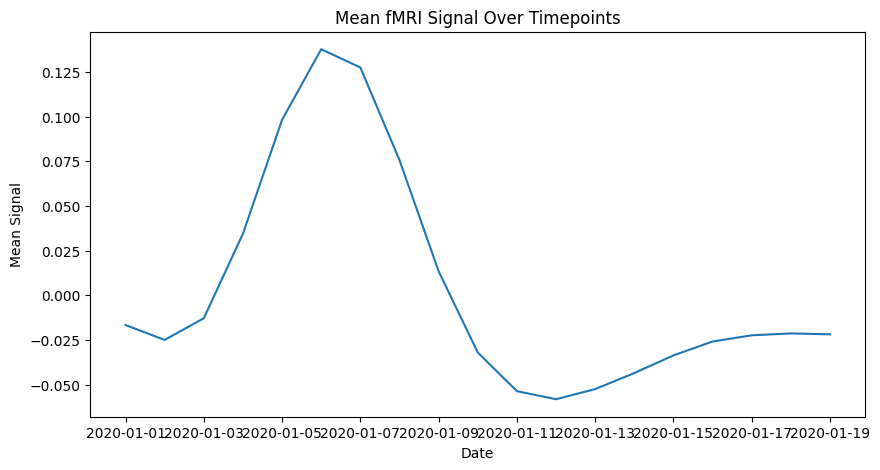

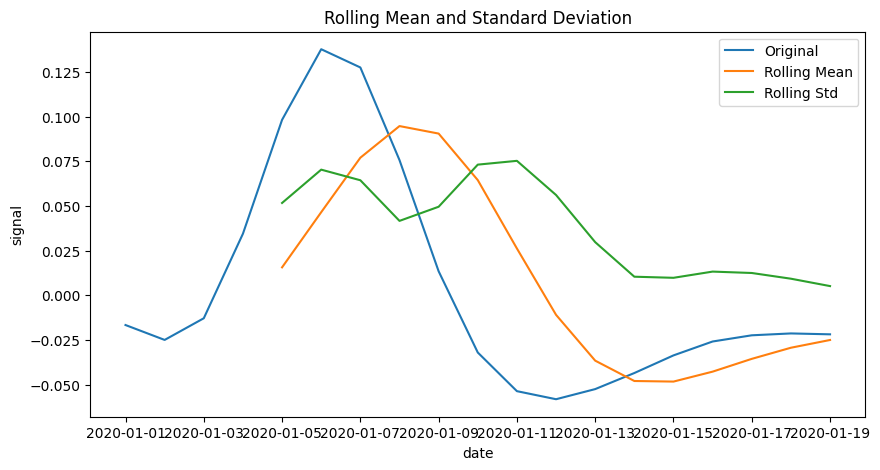

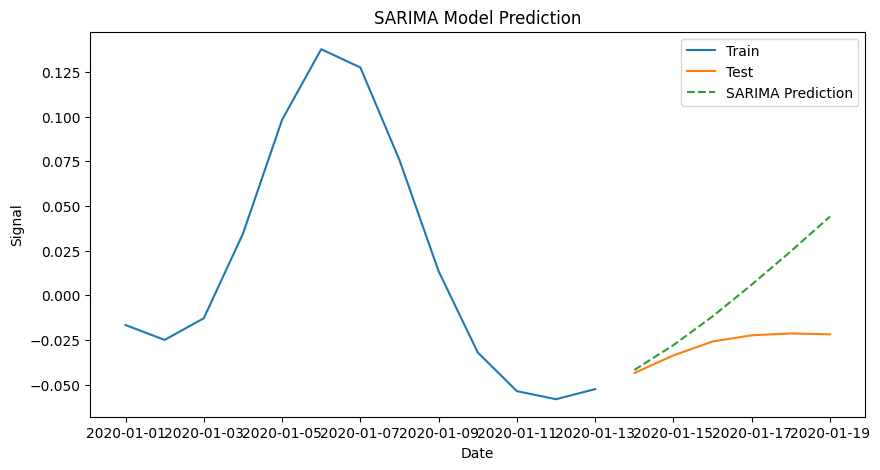

In [1]:
# In[1]: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings to reduce clutter
warnings.filterwarnings("ignore")

# In[2]: Load and Prepare Data
fmri = sns.load_dataset('fmri')

# Aggregate mean signal per timepoint
fmri_agg = fmri.groupby('timepoint')['signal'].mean().reset_index()

# Create a datetime index (simulate with days from a start date)
fmri_agg['date'] = pd.to_datetime('2020-01-01') + pd.to_timedelta(fmri_agg['timepoint'], unit='D')
fmri_agg.set_index('date', inplace=True)

# Set frequency explicitly to avoid "inferred frequency" warnings
fmri_agg.index.freq = 'D'

# In[3]: Visualize the Time Series
plt.figure(figsize=(10, 5))
sns.lineplot(data=fmri_agg, x=fmri_agg.index, y='signal')
plt.title('Mean fMRI Signal Over Timepoints')
plt.xlabel('Date')
plt.ylabel('Mean Signal')
plt.show()

# In[4]: Rolling Mean and Standard Deviation
fmri_agg['rollMean'] = fmri_agg['signal'].rolling(window=5).mean()
fmri_agg['rollStd'] = fmri_agg['signal'].rolling(window=5).std()

plt.figure(figsize=(10, 5))
sns.lineplot(data=fmri_agg, x=fmri_agg.index, y='signal', label='Original')
sns.lineplot(data=fmri_agg, x=fmri_agg.index, y='rollMean', label='Rolling Mean')
sns.lineplot(data=fmri_agg, x=fmri_agg.index, y='rollStd', label='Rolling Std')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

# In[5]: Train-Test Split
size = int(len(fmri_agg) * 0.7)
train_data = fmri_agg.iloc[:size]['signal']
test_data = fmri_agg.iloc[size:]['signal']

# In[6]: SARIMA Modeling
sarima_model = SARIMAX(train_data, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 2),
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(maxiter=500, disp=False)

# In[7]: Prediction
sarima_pred = sarima_result.predict(start=len(train_data), end=len(fmri_agg) - 1)

# In[8]: Plot Prediction vs Actual
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, sarima_pred, label='SARIMA Prediction', linestyle='--')
plt.title('SARIMA Model Prediction')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.legend()
plt.show()
